In [1]:
import numpy as np
from dff_seg.dff_seg import DFFSeg, show_segmentation_on_image
import numpy as np
from PIL import Image
from pytorch_grad_cam.utils.image import preprocess_image
from torchvision.models import resnet50
import torch
import cv2
import timm
import math
import joblib
from huggingface_hub import login

# Hugging Face Login

In the next cell, we will log in to Hugging Face using an authentication token. This step is necessary to access and download models from the Hugging Face Hub, which we'll be using in our notebook.


In [2]:
token = "<your_token>"
login(token=token)

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid.
Your token has been saved to C:\Users\User\.cache\huggingface\token
Login successful


# Transformer Reshape Transform

For using a transformer-based model, we need to define a `TransformerReshapeTransform` class as shown in the next cell. This class is essential for reshaping the output tensor from the transformer model to make it compatible with the segmentation task.

The `TransformerReshapeTransform` class performs the following operations:
1. Reshapes the input tensor
2. Applies a ReLU activation
3. Rearranges the dimensions to match the expected format for segmentation


In [3]:
class TransformerReshapeTransform:
    def __init__(self):
        self.input_tensor_shape = None

    def __call__(self, tensor):
        result = torch.nn.ReLU()(tensor[:, 1:, :].reshape(tensor.size(0),
                                self.input_tensor_shape[2] // 16,
                                self.input_tensor_shape[3] // 16,
                                tensor.size(2)))
        # Bring the channels to the first dimension,
        # like in CNNs.
        result = result.transpose(2, 3).transpose(1, 2)
        return result

# Loading and Preprocessing the Example Image

It's important to note that the UNI and Prov-GigaPath models require input images with dimensions divisible by 16.



In [4]:
def pad_divisible(img: np.ndarray, number: int = 16) -> np.ndarray:
    """
    Pad the image shape to be a multiple of number

    :param img: Input image.
    :param scale: Scale factor.
    :return: Padded input image.
    """
    w = number * math.ceil(img.shape[1] / number) - img.shape[1]
    h = number * math.ceil(img.shape[0] / number) - img.shape[0]

    if w > 0 or h > 0:
        padded = cv2.copyMakeBorder(
            img, 0, h, 0, w, borderType=cv2.BORDER_REPLICATE)
        return padded
    else:
        return img


img_path = "./images/example_3.png"
img = np.array(Image.open(img_path))[:, :, :3]
orig_shape = img.shape
img = pad_divisible(img)
rgb_img_float = np.float32(img) / 255
input_tensor = preprocess_image(rgb_img_float,
                                mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])

# Loading the Model and Getting Results on the Image

We'll load a pre-trained model and use it to generate segmentation results on our input image using the concepts (i.e. model embeddings) as the projection matrix. We'll follow these steps:

1. Choose and load a pre-trained model (UNI, GigaPath, or ResNet50)
2. Set up the target layer and any necessary transformations
3. Initialize the DFFSeg object
4. Load pre-computed model embeddings
5. Define the number of clusters and prepare the concepts
6. Generate the segmentation prediction

The code below demonstrates this process, allowing us to see how the chosen model performs on our example image.


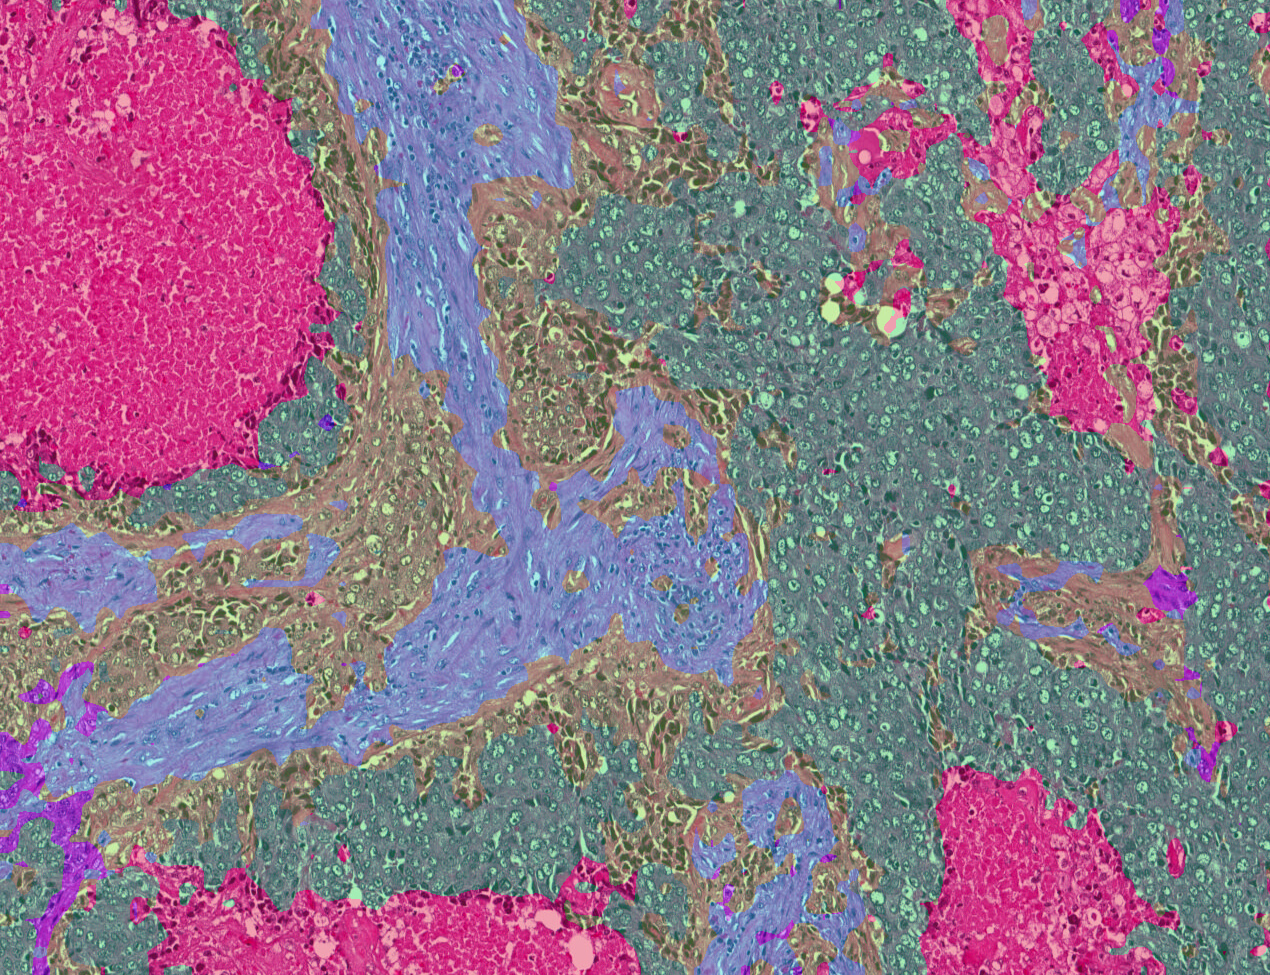

In [5]:
model_name = "uni"

if model_name == "gigapath":
    model = timm.create_model("hf_hub:prov-gigapath/prov-gigapath", pretrained=True, dynamic_img_size=True)
    target_layer = model.blocks[-1]
    transform = TransformerReshapeTransform()
if model_name == "resnet50":
    concepts = np.load("/home/gildenbj/dev/dff_seg/concepts_resnet50_concepts.npy")
    model = resnet50(pretrained=True)
    target_layer = model.layer3
    transform = None
elif model_name == "uni":
    model = timm.create_model("hf-hub:MahmoodLab/uni", pretrained=True, init_values=1e-5, dynamic_img_size=True)
    target_layer = model.blocks[-1]    
    transform = TransformerReshapeTransform()

model.eval()

unsupervised_seg = DFFSeg(
    model=model,
    target_layer=target_layer,
    reshape_transform=transform,
)

# Load the clustering models embeddings
model_embeddings = joblib.load("../model_embeddings/uni.joblib")

k = 16  # Number of clusters
unsupervised_seg.reshape_transform.input_tensor_shape = input_tensor.shape

# Define the concepts as the k-means centroids and make sure they are non-negative
concepts = model_embeddings[k]
concepts[concepts < 0] = 0

segmentation = unsupervised_seg.predict_project_concepts(input_tensor, concepts)
visualization = show_segmentation_on_image(
    img=img,
    segmentation=segmentation,
    image_weight=0.7,
    n_categories=len(concepts))

# Unpad the result segmentation to match the original image dimensions
visualization = visualization[:orig_shape[0], :orig_shape[1], :]

display(Image.fromarray(visualization))



# Using Concepts Similarity for Segmentation

In the next cell, we will use the concepts similarity approach to generate the segmentation results. This method compares the similarity between the extracted features and predefined concepts to create a segmentation map. 


C:\Users\User\AppData\Roaming\Python\Python310\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


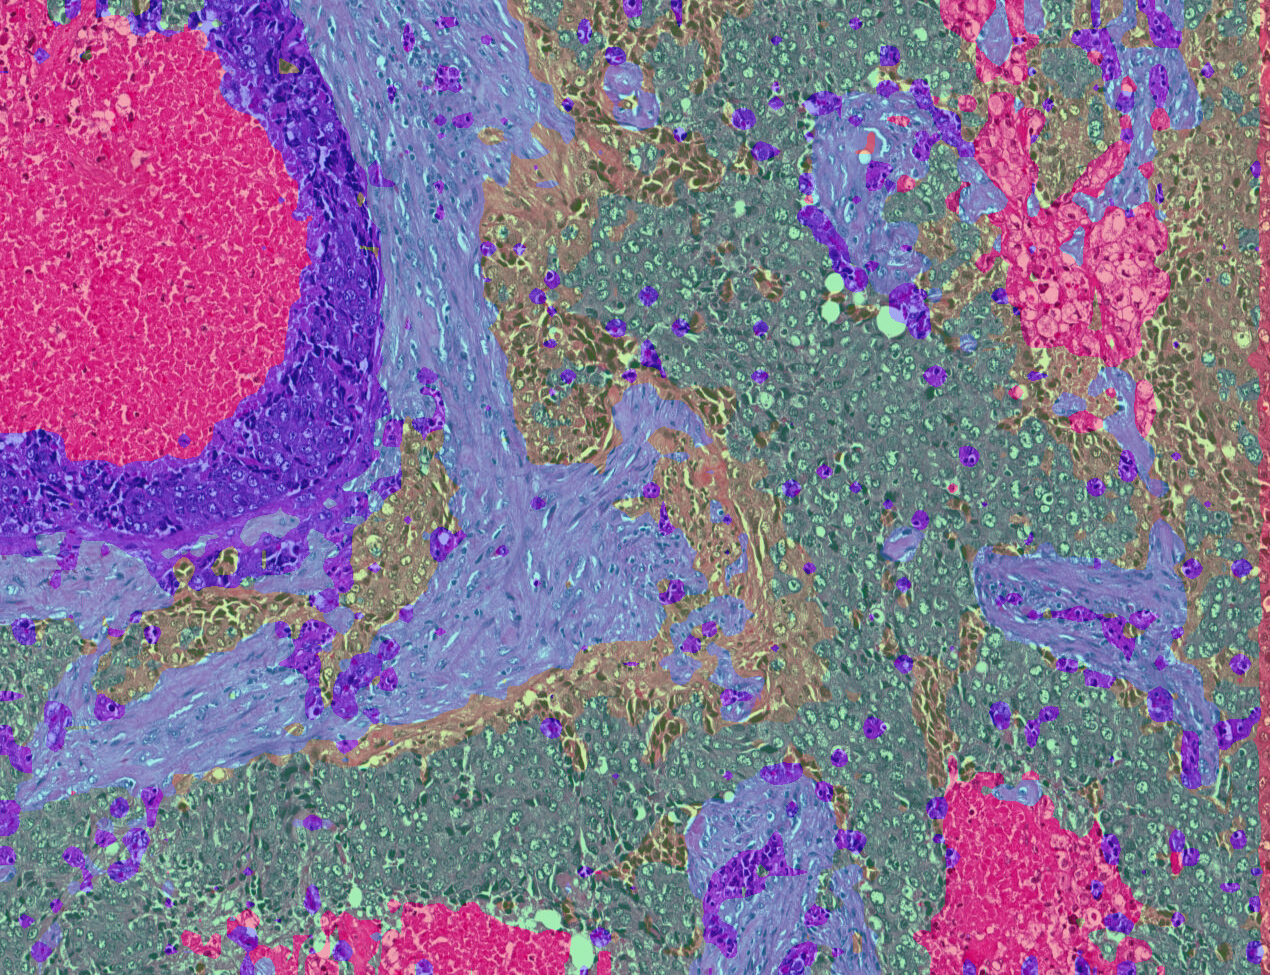

In [6]:
from sklearn.metrics.pairwise import cosine_distances

class ConceptClustering:
    def __init__(self, clusters: np.ndarray):
        """
        Clustering model based on the cosine similarity between the concept
        embeddings.

        :param clusters: The clusters centroids embeddings.

        """
        self.clusters = clusters

    def __call__(self, vector: np.ndarray) -> int:
        return cosine_distances(vector, self.clusters).argmin()

clustering_model = ConceptClustering(concepts)
segmentation = unsupervised_seg.predict_clustering(input_tensor, clustering_model)
visualization = show_segmentation_on_image(
    img=img,
    segmentation=segmentation,
    image_weight=0.7,
    n_categories=len(concepts))

# Unpad the result segmentation to match the original image dimensions
visualization = visualization[:orig_shape[0], :orig_shape[1], :]

display(Image.fromarray(visualization))